# Working with Custom Images

Let's explore what its like to work with a more realistic data set.

## The Data

----------
--------

ORIGINAL DATA SOURCE:

The dataset contains 2 folders - Infected - Uninfected

And a total of 27,558 images.

Acknowledgements
This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/ 

**Note: We will be dealing with real image files, NOT numpy arrays. Which means a large part of this process will be learning how to work with and deal with large groups of image files. This is too much data to fit in memory as a numpy array, so we'll need to feed it into our model in batches.**

### Visualizing the Data


-------
Let's take a closer look at the data.

In [1]:
#  mounts the Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

import zipfile
import os

In [ ]:
#!unrar x "/content/drive/MyDrive/cell_images.rar" "/content/drive/MyDrive/Tensorflow"

In [11]:
my_data_dir = '/content/drive/MyDrive/Tensorflow/cell_images'

In [12]:
# CONFIRM THAT THIS REPORTS BACK 'test', and 'train'
os.listdir(my_data_dir) 

['test', 'train']

In [15]:
test_path = my_data_dir+'/test'
train_path = my_data_dir+'/train'

In [16]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [17]:
os.listdir(train_path)

['parasitized', 'uninfected']

**Let's check how many images there are.**

In [19]:
len(os.listdir('/content/drive/MyDrive/Tensorflow/cell_images/test/parasitized'))

1300

In [20]:
len(os.listdir('/content/drive/MyDrive/Tensorflow/cell_images/test/uninfected'))

1300

In [21]:
len(os.listdir('/content/drive/MyDrive/Tensorflow/cell_images/train/parasitized'))

12480

In [22]:
len(os.listdir('/content/drive/MyDrive/Tensorflow/cell_images/train/uninfected'))

12480

In [23]:
os.listdir(train_path+'/parasitized')[0]

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [24]:
para_cell = train_path+'/parasitized'+'/C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [25]:
para_img = imread(para_cell)

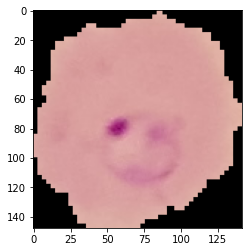

In [27]:
plt.imshow(para_img)
plt.show()

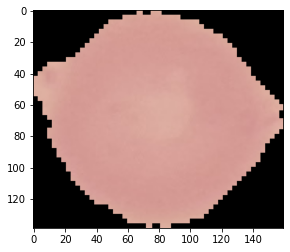

In [29]:
unifected_cell_path = train_path+'/uninfected/'+os.listdir(train_path+'/uninfected')[0]
unifected_cell = imread(unifected_cell_path)
plt.imshow(unifected_cell)
plt.show()

**Let's find out the average dimensions of these images.**

In [30]:
para_img.shape

(148, 142, 3)

In [32]:
unifected_cell.shape

(139, 160, 3)